In [2]:
#
#  Creating a pyomo parest version of example from James Rawlings Reactor Design Book
#  https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import pyomo.dae as dae
import scipy.stats as spstat

from pyomo.contrib.pynumero.interfaces.pyomo_nlp import PyomoNLP
from pyomo.contrib.pynumero.sparse import BlockSymMatrix, BlockMatrix, BlockVector
from scipy.sparse import identity
from scipy.sparse.linalg import spsolve

import get_redHessian as hess

In [2]:
data_df = pd.read_csv('hbv_data.csv')
data_df.head()

,t,ca_exp,cb_exp,cc_exp
0,0.0,0.734562,0.000000,0.000000
1,2.0,0.707371,3.444986,373.654198
2,4.0,0.521003,6.148200,280.451066
3,6.0,0.680192,7.458215,301.503717
4,8.0,0.716159,8.115554,363.551492


In [3]:
data = [{'ca_exp': {k: v for (k, v) in zip(data_df.t, data_df.ca_exp)},
         'cb_exp': {k: v for (k, v) in zip(data_df.t, data_df.cb_exp)},
         'cc_exp': {k: v for (k, v) in zip(data_df.t, data_df.cc_exp)}
        }]

In [10]:
def hbv_model(data):
    
    ca_exp = data['ca_exp']
    cb_exp = data['cb_exp']
    cc_exp = data['cc_exp']
    texp = list(ca_exp.keys())
    
    ca0 = 1.0
    cb0 = 0.0
    cc0 = 0.0
    
    m = pyo.ConcreteModel()
    
    m.k1 = pyo.Var(initialize = 6.3, bounds = (1e-3, 10))
    m.k2 = pyo.Var(initialize = 0.07, bounds = (1e-3, 10))
    m.k3 = pyo.Var(initialize = 1412, bounds = (100, 5000))
    m.k4 = pyo.Var(initialize = 0.17, bounds = (1e-3, 10))
    m.k5 = pyo.Var(initialize = 0.69, bounds = (1e-3, 10))
    m.k6 = pyo.Var(initialize = 3.5e-6, bounds = (1e-6, 1e-5))
    
    m.time = dae.ContinuousSet(bounds = (0, max(texp)), initialize = texp)
    
    m.ca = pyo.Var(m.time, initialize = ca0)
    m.cb = pyo.Var(m.time, initialize = cb0)
    m.cc = pyo.Var(m.time, initialize = cc0)
    
    m.dca = dae.DerivativeVar(m.ca)
    m.dcb = dae.DerivativeVar(m.cb)
    m.dcc = dae.DerivativeVar(m.cc)
    
    def _dca_eq(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dca[t] == m.k2 * m.cb[t] - m.k4 * m.ca[t]
    m.dca_eq = pyo.Constraint(m.time, rule = _dca_eq)

    def _dcb_eq(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dcb[t] == m.k1 * m.ca[t] - m.k2 * m.cb[t] - m.k6 * m.cb[t] * m.cc[t]
    m.dcb_eq = pyo.Constraint(m.time, rule = _dcb_eq)
    
    def _dcc_eq(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dcc[t] == m.k3 * m.ca[t] - m.k5 * m.cc[t] - m.k6 * m.cb[t] * m.cc[t]
    m.dcc_eq = pyo.Constraint(m.time, rule = _dcc_eq)

    def _initcon(m):
        yield m.ca[m.time.first()] == ca0
        yield m.cb[m.time.first()] == cb0
        yield m.cc[m.time.first()] == cc0
    m.initcon = pyo.ConstraintList(rule = _initcon)
        
    def wssq_rule(m):
        return sum((m.ca[t] - ca_exp[t]) ** 2 + 
                   1e-2 * (m.cb[t] - cb_exp[t]) ** 2 + 
                   1e-4 * (m.cc[t] - cc_exp[t]) ** 2 
                   for t in texp) 
    m.wssq = pyo.Objective(rule=wssq_rule)
   
    disc = pyo.TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=60, ncp=4)
    
    #disc = TransformationFactory('dae.finite_difference')
    #disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m 

In [11]:
# Estimate parameters
mest = hbv_model(data[0])
solver = pyo.SolverFactory('ipopt')
solver.solve(mest, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     8883
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2073

Total number of variables............................:     1449
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6


  74  7.2661528e+04 1.28e+02 1.21e+13  -1.0 2.08e+02   0.9 2.84e-03 1.00e+00h  1
  75  6.6633435e+04 9.63e+00 2.55e+10  -1.0 1.63e+02   1.3 2.72e-05 1.00e+00f  1
  76  6.3197913e+04 3.72e+02 1.86e+12  -1.0 5.16e+02   0.8 1.13e-01 3.61e-01f  1
  77  6.0916228e+04 8.18e+02 1.97e+13  -1.0 2.01e+03   0.4 1.00e+00 1.00e+00f  1
  78  5.8401480e+04 8.76e+02 1.31e+13  -1.0 8.56e+02   1.7 9.23e-02 1.56e-01f  1
MUMPS returned INFO(1) = -9 and requires more memory, reallocating.  Attempt 1
  Increasing icntl[13] from 4000 to 8000.
  79  5.8606801e+04 8.75e+02 1.31e+13  -1.0 2.92e+03   1.2 1.93e-01 1.76e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  6.3459984e+04 7.06e+02 1.27e+13  -1.0 2.44e+02   1.6 5.17e-04 1.93e-01h  2
  81  6.6169423e+04 1.53e+03 3.60e+12  -1.0 4.62e+02   1.2 4.00e-02 1.00e+00h  1
  82  6.7373367e+04 1.46e+03 2.22e+12  -1.0 4.84e+02   2.5 2.03e-01 4.31e-02h  3
  83  6.8741412e+04 1.31e+03 6.24e+11  -1.0 1.97e+02   2.9 1.00e+00 1

 166  1.3157559e+04 4.18e-11 1.53e-07  -8.6 1.07e-11    -  1.00e+00 1.00e+00H  1
 167  1.3157559e+04 4.19e-11 9.91e-07  -8.6 1.66e-11    -  1.00e+00 1.25e-01h  4
 168  1.3157559e+04 2.83e-11 1.78e-06  -8.6 1.12e-11    -  1.00e+00 5.00e-01h  2
 169  1.3157559e+04 3.00e-11 5.41e-07  -8.6 1.52e-11    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.3157559e+04 3.15e-11 7.95e-08  -8.6 1.48e-11    -  1.00e+00 2.50e-01h  3
 171  1.3157559e+04 3.04e-11 1.32e-07  -8.6 9.36e-12    -  1.00e+00 5.00e-01h  2
 172  1.3157559e+04 3.59e-11 1.39e-06  -8.6 9.70e-12    -  1.00e+00 5.00e-01h  2
 173  1.3157559e+04 4.30e-11 4.88e-07  -8.6 1.63e-11    -  1.00e+00 2.50e-01h  3
 174  1.3157559e+04 2.37e-11 8.10e-07  -8.6 1.22e-11    -  1.00e+00 5.00e-01h  2
 175  1.3157559e+04 3.93e-11 7.46e-07  -8.6 1.27e-11    -  1.00e+00 1.00e+00h  1
 176  1.3157559e+04 3.31e-11 8.64e-07  -8.6 1.72e-11    -  1.00e+00 1.00e+00H  1
 177  1.3157559e+04 3.90e-11

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1443, 'Number of variables': 1449, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Solved To Acceptable Level.', 'Termination condition': 'optimal', 'Id': 1, 'Error rc': 0, 'Time': 48.23748207092285}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
# Parameter Estimates
parest = {'k1': mest.k1(), 'k2': mest.k2(), 'k3': mest.k3(), 'k4': mest.k4(), 'k5': mest.k5(), 'k6': mest.k6()}
parest

{'k1': 2.049943771430941,
 'k2': 0.019406624245646372,
 'k3': 192.93788256852608,
 'k4': 0.19027088517692115,
 'k5': 0.3690144565767498,
 'k6': 8.234443443279068e-06}

In [13]:
nlp = PyomoNLP(mest)
parm_vars = [mest.k1, mest.k2, mest.k3, mest.k4, mest.k5, mest.k6]
Hred = hess.getHred(nlp, parm_vars)
print("Hessian from pynumero:")
print(Hred)

Hessian from pynumero:
[[ 1.65245408e+06  1.51328966e+08  8.32245944e+02 -1.50637920e+07
  -5.27411498e+05 -2.11162324e+11]
 [ 1.51328966e+08  1.41531755e+10  1.05162558e+05 -1.40791385e+09
  -6.28917574e+07 -1.93376693e+13]
 [ 8.32245944e+02  1.05162558e+05  8.06128272e+00 -8.71175255e+03
  -3.96708226e+03  3.53489575e+07]
 [-1.50637920e+07 -1.40791385e+09 -8.71175255e+03  1.41590892e+08
   5.46289721e+06  2.04759002e+12]
 [-5.27411498e+05 -6.28917574e+07 -3.96708226e+03  5.46289721e+06
   1.99414739e+06  4.72284565e+09]
 [-2.11162324e+11 -1.93376693e+13  3.53489575e+07  2.04759002e+12
   4.72284565e+09  3.71893156e+16]]


In [15]:
n = len(data[0]['ca_exp']) + len(data[0]['cb_exp']) + len(data[0]['cc_exp'])
p = 6
s2 = mest.wssq() / (n - p)
print('n:', n, ' p:', p, ' s2:', s2)
# Covariance Matrix
cov = 2 * s2 * np.linalg.inv(Hred)
cov

n: 153  p: 6  s2: 89.50720723269252


matrix([[ 1.39584691e-02, -5.31484542e-04, -1.34211930e+00,
         -4.53211672e-03, -3.45293090e-03,  5.41418300e-08],
        [-5.31484542e-04,  3.51599581e-05,  1.07276553e-01,
          3.54851698e-04,  2.20049519e-04, -4.40287849e-09],
        [-1.34211930e+00,  1.07276553e-01,  1.97005785e+03,
          1.15317032e+00,  3.83032832e+00, -1.76899222e-05],
        [-4.53211672e-03,  3.54851698e-04,  1.15317032e+00,
          3.71046785e-03,  2.23315050e-03, -4.68907431e-08],
        [-3.45293090e-03,  2.20049519e-04,  3.83032832e+00,
          2.23315050e-03,  7.69635272e-03, -3.27569233e-08],
        [ 5.41418300e-08, -4.40287849e-09, -1.76899222e-05,
         -4.68907431e-08, -3.27569233e-08,  6.25538925e-13]])

In [17]:
parm_sd = np.sqrt(np.diag(cov))
conf_mult = np.sqrt(p * spstat.f.ppf(0.95, p, n - p))
print("conf multiplier:", conf_mult)
conf_int = conf_mult * parm_sd
print("confidence interval delta from nominal [k1, k2, k3, k4, k5, k6]")
print(conf_int)

conf multiplier: 3.600647920002456
confidence interval delta from nominal [k1, k2, k3, k4, k5, k6]
[4.25402024e-01 2.13503418e-02 1.59815960e+02 2.19328462e-01
 3.15880734e-01 2.84778912e-06]


In [18]:
ms = hbv_model(data[0])
ms.k1.fix(mest.k1())
ms.k2.fix(mest.k2())
ms.k3.fix(mest.k3())
ms.k4.fix(mest.k4())
ms.k5.fix(mest.k5())
ms.k6.fix(mest.k6())

solver = pyo.SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     6963
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      393

Total number of variables............................:     1443
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1443, 'Number of variables': 1443, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.09953618049621582}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

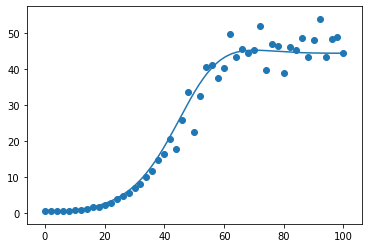

In [19]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.ca[t]() for t in ms.time])
ax.scatter(data[0]['ca_exp'].keys(), data[0]['ca_exp'].values())

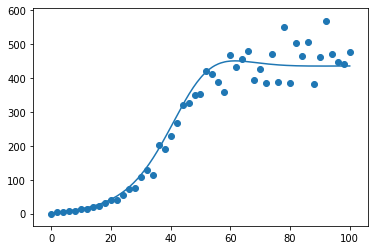

In [20]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.cb[t]() for t in ms.time])
ax.scatter(data[0]['cb_exp'].keys(), data[0]['cb_exp'].values())

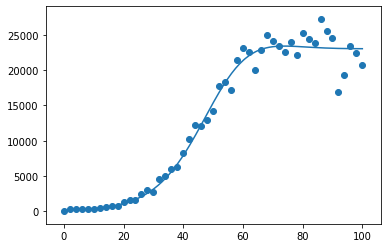

In [21]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.cc[t]() for t in ms.time])
ax.scatter(data[0]['cc_exp'].keys(), data[0]['cc_exp'].values())